<div style="direction:rtl">
    <font style="font-family:'Courier New';font-weight:bold;color:Black" size="5">
پروژه CA4 : استفاده از روش RNN برای POS Tagging
    </font>
</div>

In [36]:
import warnings; warnings.simplefilter('ignore')

In [37]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#os.environ["CUDA_VISIBLE_DEVICES"]="0"  # or if you want more than 1 GPU set it as "0", "1"

In [38]:
import xlrd 
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
در بخش اول پس از خواندن فایل Rnn_train.xlsx، متدی به نام sents_tags_tokenize  نوشته شده که اطلاعات دادگان آموزشی را خوانده و چهار لیست برمی گرداند. یک لیست برای sequence های جملات و یک لیست حاوی sequence های تگهای صحیح متناظر و همچنین لیست کلیه کلمات و لیست کلیه تگها را بر می گرداند. همچنین در این متد تگ _PAD_  به ابتدا و انتهای هر جمله در لیستهای خروجی اضافه شده است.
</font>
</div>

In [39]:
train_wb = xlrd.open_workbook('data/Rnn_train.xlsx') 
train_sheet = train_wb.sheet_by_index(0) 

In [40]:
def sents_tags_tokenize(data_sheet, padded, pad_symbol):
    sents = []
    sents_tags = []

    all_words = []
    all_tags = []
    
    curr_s = ''
    curr_sent=[]
    curr_sent_tags=[]
    for i in range(data_sheet.nrows):
    #for i in range(500):    
        row = data_sheet.row_values(i)
        s,w,t = row[0], row[1], row[2]
        if (curr_s == ''):
            curr_s = s 
            if padded == True:
                curr_sent.append(pad_symbol)
                curr_sent_tags.append(pad_symbol)
                
        elif s != '':
            curr_s = s
            if padded == True:
                curr_sent.append(pad_symbol)
                curr_sent_tags.append(pad_symbol)
            sents.append(curr_sent)
            sents_tags.append(curr_sent_tags)
            
            curr_sent=[]
            curr_sent_tags=[]
            if padded == True:
                curr_sent.append(pad_symbol)
                curr_sent_tags.append(pad_symbol)

        curr_sent.append(str(w))
        curr_sent_tags.append(t)
        
        all_words.append(str(w).lower())
        all_tags.append(t)

    if  len(curr_sent) > 0:
        if padded == True:
            curr_sent.append(pad_symbol)
            curr_sent_tags.append(pad_symbol)
        
        sents.append(curr_sent)
        sents_tags.append(curr_sent_tags)
        
        all_words.append(str(w).lower())
        all_tags.append(t)

    all_words.append(pad_symbol)
    all_words.append('_OOV_')
    all_tags.append(pad_symbol)    
    return sents, sents_tags, all_words, all_tags

In [41]:
sents, sents_tags, all_words, all_tags = sents_tags_tokenize(train_sheet, padded=True, pad_symbol='_PAD_')

In [42]:
print("len of sents:",len(sents),"\nlen of sents_tags:",len(sents_tags))
print("\nlen of all_words:",len(all_words),"\nlen of all_tags:", len(all_tags))
print("--------------------------")
print("sample sentence : ", sents[1])
print("sample sentence tags : ", sents_tags[1])

len of sents: 20001 
len of sents_tags: 20001

len of all_words: 437960 
len of all_tags: 437959
--------------------------
sample sentence :  ['_PAD_', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', '_PAD_']
sample sentence tags :  ['_PAD_', 'NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.', '_PAD_']


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
ماکزیمم طول جملات در دادگان آموزشی را بدست می آوریم. این عدد برای تعیین طول sequence های ورودی شبکه RNN استفاده می شود
</font>
</div>

In [43]:
MAX_LENGTH = len(max(sents, key=len))
print(MAX_LENGTH) 

72


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
برای تخصیص یک عدد به هر کلمه از vocab و همچنین تخصیص یک عدد به هر تگ و سپس استفاده از این اعداد برای تولید بردارهای one-hot از کلاسهای LabelEncoder و OneHotEncodel از کتابخانه sklearn.preprocessing استفاده شد
</font>
</div>

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

words_encoder = LabelEncoder()
words_encoder.fit_transform(all_words)

array([20813, 19148, 13578, ...,    19,  1213,  1212], dtype=int64)

In [45]:
tags_encoder = LabelEncoder()
integer_encoded = tags_encoder.fit_transform(all_tags)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

tags_onehot_encoder = OneHotEncoder(sparse=False, dtype='uint8')
tags_onehot_encoder.fit_transform(integer_encoded)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
سایز vocab و سایز tagset بدست آورده شد و _OOV_ به مجموعه کلمات vocab افزوده شده است. لازم به ذکر است که _PAD_ به هر دو مجموعه اضافه شده است
</font>
</div>

In [46]:
vocab_size = len(words_encoder.classes_)
tagset_size = len(tags_encoder.classes_)
print("vocab_size:", vocab_size, "   tagset_size:", tagset_size)

vocab_size: 21126    tagset_size: 42


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
برای صحت عملکرد انکدرها، برای تگ و کلمه نمونه ای تست شده است
</font>
</div>

In [47]:
d = tags_onehot_encoder.transform([tags_encoder.transform(["DT"])])
print("one-hot vector of word \"DT\": ", d[0])
print("invert of code 24: ", tags_encoder.inverse_transform([24]))


one-hot vector of word "DT":  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
invert of code 24:  ['RBR']


In [48]:
print("invert of code 2004: ", words_encoder.inverse_transform([2004]))
print("transform of word \"the\" to code: ", words_encoder.transform(["the"])[0])

invert of code 2004:  ['ambulance']
transform of word "the" to code:  19083


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
متد زیر، لیست جملات را می گیرد که در این لیست، هر جمله خودش لیستی از کلمات می باشد. سپس هر کلمه از هر جمله را به ایندکس متناظرش انکد کرده و لیستی از جملات حاوی کلمات انکد شده را برمی گرداند.
</font>
</div>

In [49]:
def encode_sents(sents):
    X_sents = []
    for s in sents:
        X_currr_s = []
        for w in s:
            try:
                X_currr_s.append(words_encoder.transform([w.lower()])[0])
            except:
                X_currr_s.append(words_encoder.transform(['_OOV_'])[0])
        X_sents.append(X_currr_s)
    return X_sents    

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
متد زیر، لیست تگهای جملات را می گیرد که در این لیست، هر جمله خودش لیستی از تگهای کلمات می باشد. سپس هر تگ از هر جمله را به ایندکس متناظرش انکد کرده و لیستی از جملات حاوی تگهای انکد شده را برمی گرداند.
</font>
</div>

In [50]:
def encode_sents_tags(sents_tags):
    Y_sents_tags = []
    for s in sents_tags:
        Y_currr_s = []
        for w in s:
            try:
                Y_currr_s.append(tags_encoder.transform([w])[0])
            except:
                Y_currr_s.append(tags_encoder.transform(['_PAD_'])[0])
        Y_sents_tags.append(Y_currr_s)
    return Y_sents_tags    

In [187]:
X_sents = encode_sents(sents)

Y_sents_tags = encode_sents_tags(sents_tags)

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
نمونه خروجی دو متد بالا نشان داده شده است
</font>
</div>

In [188]:
print(len(X_sents),len(Y_sents_tags))
print(X_sents[1])
print(Y_sents_tags[1])

20001 20001
[1212, 19148, 13578, 5883, 9132, 11933, 19183, 11557, 19263, 15169, 19083, 20480, 9809, 10270, 2078, 5845, 19083, 20770, 13578, 3676, 19564, 8222, 19081, 5297, 19, 1212]
[40, 18, 9, 18, 34, 33, 9, 16, 28, 30, 7, 15, 9, 16, 5, 30, 7, 15, 9, 10, 18, 9, 7, 15, 2, 40]


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
با توجه به اینکه ورودی مدل RNN در کتابخانه keras باید دارای طول یکسان برای sequence های ورودی باشد لذا هر جمله به اندازه ماکزیمم طول جملات که 72 بود pad شده است
</font>
</div>

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
مقدار پیش فرض برای padding عدد 0 است اما چون در اینجا عدد 0 برای ایندکس تگ هم استفاده شده لذا از مقدار 50 برای  padding تگها استفاده شده است
</font>
</div>

In [202]:
X_sents_padded = pad_sequences(X_sents, maxlen=MAX_LENGTH, padding='post')
Y_sents_tags_padded = pad_sequences(Y_sents_tags, maxlen=MAX_LENGTH, padding='post', value=50)

In [203]:
Y_sents_tags_padded[0]

array([40, 20, 40, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50])

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
با توجه به اینکه برای خروجی شبکه RNN می خواهیم به ازای هر کلمه از sequence ورودی، یک تگ را مشخص کند لذا لازم است که مقدار Y برای هر X ورودی بردار on-hot مربوط به تگ متناظر آن باشد. متد زیر خروجی مورد انتظار از sequence های ورودی را گرفته و سپس به ازای هر ایندکس تگ خروجی، بردار one-hot آنرا جایگزین می کند.
</font>
</div>

In [51]:
def encode_to_onehot(Y_sents_tags_padded):
    Y_onehot_tags = []
    for s_tags in Y_sents_tags_padded:
        t_final=[]
        for c in s_tags:
            if c >= 0:
                d = tags_onehot_encoder.transform(np.array([c]).reshape(-1,1))
                t_final.append(d[0])
            else:
                t_final.append(np.zeros(tagset_size))
        Y_onehot_tags.append(t_final)    
    Y_onehot_tags = np.array(Y_onehot_tags)
    return Y_onehot_tags

In [191]:
Y_onehot_tags = encode_to_onehot(Y_sents_tags_padded)

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
همانطور که در زیر هم نشان داده شده است، ورودی شبکه RNN ماتریسی با ابعاد تعداد جملات ضرب در طول sequenceها که در اینجا 72 است می باشد. خروجی شبکه RNN هم ماتریسی با ابعاد تعداد جملات در طول sequence در تعداد تگها که در اینجا 42 است می باشد
</font>
</div>

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
در واقع هر یک از بردارهای 42 تایی خروجی از تابع softmax لایه آخر شبکه باید بدست آید.
</font>
</div>

In [198]:
print("input shape for model:" , X_sents_padded.shape)
print("output shape of model:" , Y_onehot_tags.shape)

input shape for model: (20001, 72)
output shape of model: (20001, 72, 42)


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
متد زیر، مدل شبکه مورد نظر را می سازد. ابعاد لایه ورودی همانطور که در بالا هم گفته شد، تعداد جملات در طول padded sequence هر جمله است. که در اینجا می شود 20001*72 
</font>
</div>

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
سپس از یک لایه Embedding استفاده شده است تا بردارهای ورودی در برداری 128 تایی embed شوند
</font>
</div>

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
سپس یک لایه Bi-LSTM و با توجه به داشتن خروجی در هر مرحله زمانی از لایه Dense TimeDistributed استفاده شده است
</font>
</div>

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
در انتها هم تابع softmax به عنوان activation function لایه آخر استفاده شده و categorical_crossentropy هم به عنوان تابع loss تعیین شده است زیرا مساله چندکلاسه است و به تعداد تگها، کلاس خروجی داریم.
</font>
</div>

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
نرخ یادگیری هم 0.01 درنظر کرفته شد</font>
</div>

In [52]:

def build_model(MAX_LENGTH, vocab_size, tagset_size):
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_LENGTH, )))
    model.add(Embedding(vocab_size, 128,input_length=MAX_LENGTH))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    #model.add(LSTM(128, return_sequences=True))
    #model.add(LSTM(units=128))
    model.add(TimeDistributed(Dense(tagset_size)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])
    return model

In [53]:
def train_model(model, model_filepath, pretrained_weights, epoch_num):
    if (pretrained_weights == True):
        model.load_weights(model_filepath)
    #--------------------------------------
    checkpointer = ModelCheckpoint(model_name, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit(X_sents_padded, batch_size=32, y=Y_onehot_tags, verbose=1, validation_split=0.2, 
                        shuffle=True, epochs=epoch_num, callbacks=[checkpointer])    
    return history

In [200]:
print("MAX_LENGTH:", MAX_LENGTH)
print("vocab_size:", vocab_size)
print("tagset_size:", tagset_size)
model = build_model(MAX_LENGTH, vocab_size, tagset_size)
model.summary()

MAX_LENGTH: 72
vocab_size: 21126
tagset_size: 42
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 72, 128)           2704128   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 72, 512)           788480    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 72, 42)            21546     
_________________________________________________________________
activation_4 (Activation)    (None, 72, 42)            0         
Total params: 3,514,154
Trainable params: 3,514,154
Non-trainable params: 0
_________________________________________________________________


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
با توجه به اینکه امکان آموزش مدل روی GPU فراهم نبود، لذا فرایند آموزش آن بسیار به کندی انجام شده و امکان تکرار تستهای مختلف با پارامترهای متفاوت برای رسیدن به نتیجه بهتر مقدور نبود
</font>
</div>

In [31]:
model_name="model_pos_tagger.hdf5" 
history = train_model(model, model_filepath = model_name, pretrained_weights=True, epoch_num=20)

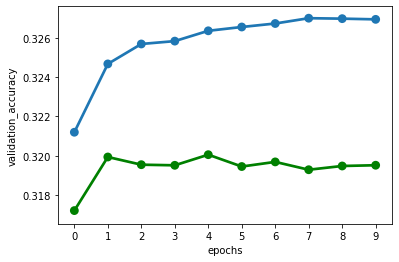

In [27]:
import seaborn as sns
import pandas as pd 

df_result = pd.DataFrame({'epochs':history.epoch, 
                          'accuracy': history.history['acc'], 
                          'validation_accuracy': history.history['val_acc']})

g = sns.pointplot(x="epochs", y="accuracy", data=df_result, fit_reg=False)

g = sns.pointplot(x="epochs", y="validation_accuracy", data=df_result, 
                  fit_reg=False, color='green')

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
بعد از آموزش مدل، از دادگان تست برای ارزیابی مدل استفاده شد.مشابه عملیاتی که برای داده های train اتجام شد تا قابل تغذیه به شبکه RNN شود، اینبار برای دادگان تست صورت گرفت.
</font>
</div>

In [56]:
test_wb = xlrd.open_workbook('data/Rnn_test.xlsx') 
test_sheet = test_wb.sheet_by_index(0) 

In [102]:
test_sents, test_sents_tags, test_all_words, test_all_tags = sents_tags_tokenize(test_sheet, padded=True, pad_symbol='_PAD_')

In [103]:
print("len of test_sents:",len(test_sents),"\nlen of test_sents_tags:",len(test_sents_tags))
print("\nlen of test_all_words:",len(test_all_words),"\nlen of test_all_tags:", len(test_all_tags))
print("--------------------------")
print("sample sentence : ", test_sents[1])
print("sample sentence tags : ", test_sents_tags[1])

len of test_sents: 5000 
len of test_sents_tags: 5000

len of test_all_words: 108827 
len of test_all_tags: 108826
--------------------------
sample sentence :  ['_PAD_', 'There', 'is', 'a', 'potential', 'source', 'of', 'income', 'from', 'harvesting', 'finfish', 'and', 'krill', '.', '_PAD_']
sample sentence tags :  ['_PAD_', 'EX', 'VBZ', 'DT', 'JJ', 'NN', 'IN', 'NN', 'IN', 'VBG', 'NN', 'CC', 'NN', '.', '_PAD_']


In [104]:
X_test_sents = encode_sents(test_sents)
Y_test_sents_tags = encode_sents_tags(test_sents_tags)

In [105]:
print(len(X_test_sents),len(Y_test_sents_tags))
print(X_test_sents[1])
print(Y_test_sents_tags[1])

5000 5000
[1212, 19105, 10299, 1214, 14780, 17889, 13578, 9846, 8222, 9098, 1212, 2078, 1212, 19, 1212]
[40, 8, 35, 7, 10, 15, 9, 15, 9, 32, 15, 5, 15, 2, 40]


In [106]:
X_test_sents_padded = pad_sequences(X_test_sents, maxlen=MAX_LENGTH, padding='post')
Y_test_sents_tags_padded = pad_sequences(Y_test_sents_tags, maxlen=MAX_LENGTH, padding='post', value=0)

In [107]:
Y_test_sents_tags_padded[1]

array([40,  8, 35,  7, 10, 15,  9, 15,  9, 32, 15,  5, 15,  2, 40,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

In [108]:
Y_test_onehot_tags = encode_to_onehot(Y_test_sents_tags_padded)

In [109]:
print("input shape for model:" , X_test_sents_padded.shape)
print("output shape of model:" , Y_test_onehot_tags.shape)

input shape for model: (5000, 72)
output shape of model: (5000, 72, 42)


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
برای تست 5000 جمله در اختیار داریم که آنها را بصورت sequnceهای با طول 72 که مدل را بر آن اساس ساخته ایم، تبدیل کرده و به شبکه می دهیم. هرچند که در جملات تست، جملاتی با طول بیش از 72 وجود دارد؛ در واقع آنها را truncate کرده ایم
</font>
</div>

In [110]:
scores = model.evaluate(X_test_sents_padded, Y_test_onehot_tags)
print(f"{model.metrics_names[1]}: {scores[1] * 100}")   

5000/5000 [==============================] - 11s 2ms/step
acc: 31.159999923706057


<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
نتیجه ارزیابی مدل برای معیار accuracy برابر 0.31 می باشد.
</font>
</div>

In [111]:
scores

[8.910435159301757, 0.31159999923706055]

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
 برای پیش بینی تگها برای داده های تست بصورت زیر عمل می کنیم و میتوان از خروجی تابع predict استفاده کرد.
</font>
</div>

In [112]:
Y_test_pred = model.predict(X_test_sents_padded)
Y_test_pred_class = model.predict_classes(X_test_sents_padded)

In [113]:
print(Y_test_pred.shape)
print(Y_test_pred_class.shape)

(5000, 72, 42)
(5000, 72)


In [114]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

<div style="direction:rtl">
<font style="font-family:verdana" size="3" color="Black">    
باید ماتریس خروجی شبکه را پردازش نموده و به ازای هر کلمه از هر جمله، ایندکس تگ خروجی را از خروجی تابع softmax بدست آورده و به تگ متناظرش برسیم.
</font>
</div>

In [115]:
print(Y_test_sents_tags_padded.shape)
print(Y_test_pred.shape)

y_test=[]
y_pred=[]
for i in range(len(Y_test_sents_tags_padded)):
    for j in range(len(Y_test_sents_tags_padded[i])):
        if Y_test_sents_tags_padded[i][j] != 0:
            y_test.append(Y_test_sents_tags_padded[i][j])
            #y_pred.append(np.argmax(Y_test_pred[i][j]))
            y_pred.append(Y_test_pred_class[i][j])

print("len of y_test:", len(y_test))
print("len of y_pred:", len(y_pred))
print("\nsample y_test:", y_test[20000:20100])
print("\nnsample y_pred:", y_pred[20000:20100])

(5000, 72)
(5000, 72, 42)
len of y_test: 118621
len of y_pred: 118621

sample y_test: [23, 10, 9, 7, 15, 35, 9, 15, 2, 40, 40, 21, 35, 33, 9, 32, 18, 9, 10, 15, 9, 7, 16, 15, 2, 40, 40, 23, 1, 18, 34, 18, 33, 9, 18, 9, 10, 16, 20, 16, 15, 1, 36, 35, 33, 9, 16, 17, 2, 40, 40, 10, 10, 16, 18, 34, 33, 7, 15, 15, 9, 16, 9, 7, 16, 3, 5, 31, 21, 14, 30, 11, 15, 9, 16, 5, 16, 2, 40, 40, 7, 15, 9, 18, 9, 33, 15, 16, 16, 35, 33, 33, 10, 2, 40, 40, 7, 10, 15, 35]

nsample y_pred: [23, 10, 9, 7, 15, 35, 9, 15, 2, 40, 40, 21, 35, 33, 9, 32, 18, 9, 10, 15, 9, 7, 16, 15, 2, 40, 40, 23, 1, 18, 34, 18, 31, 9, 18, 9, 10, 16, 20, 16, 15, 1, 36, 35, 33, 9, 16, 17, 2, 40, 40, 10, 10, 16, 18, 34, 33, 7, 15, 15, 9, 16, 9, 7, 16, 3, 5, 31, 21, 14, 30, 11, 32, 9, 16, 5, 16, 2, 40, 40, 7, 15, 9, 18, 9, 33, 40, 16, 40, 35, 33, 33, 10, 2, 40, 40, 7, 40, 15, 18]


In [120]:
print("precision : ", precision_score(y_test, y_pred, average="micro"))
print("recall : ", recall_score(y_test, y_pred, average="micro")) 
print("f1_score : ", f1_score(y_test, y_pred, average="micro"))
print("accuracy_score : ", accuracy_score(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))

precision :  0.945667293312314
recall :  0.945667293312314
f1_score :  0.945667293312314
accuracy_score :  0.945667293312314


In [116]:
print(Y_test_pred.shape)
print(Y_test_sents_tags_padded.shape)

pad_tag_ind = tags_encoder.transform(['_PAD_'])[0]

test_pred_tags=[]
for i in range(len(test_sents)):
    for j in range(min(len(test_sents_tags[i]),MAX_LENGTH)):        
        if Y_test_sents_tags_padded[i][j] != pad_tag_ind:
            tag_test = tags_encoder.inverse_transform([Y_test_sents_tags_padded[i][j]])[0]
            #if tag_test != '_PAD_':
            pair_tags=[]
            pair_tags.append(tag_test)
            pair_tags.append(tags_encoder.inverse_transform([np.argmax(Y_test_pred[i][j])])[0])
            test_pred_tags.append(pair_tags)                

(5000, 72, 42)
(5000, 72)


In [119]:
test_rnn_file = open('test_rnn_file.csv', "w")    
np.savetxt(test_rnn_file, test_pred_tags, fmt="%s", delimiter=",")
test_rnn_file.close()